## ESoWC 2019: Data-driven feature selection towards improving forecast-based prediction of wildfire hazard

Team: [@mariajoaosousa](https://github.com/mariajoaosousa), [@eduardogfma](https://github.com/eduardogfma)

Project github page: [https://github.com/esowc/ml_fire](https://github.com/esowc/ml_fire)

# Support Vector Machine II

This is the 2nd of 3 notebooks in which the necessary conditions to model the relationship between FWI and a set of different features are investigated. To do so, the methodology is based on the Support Vector Machine (SVM) framework, in which the features used to train the model are incrementally input. The reason for this incremental approach is two fold: (1) control the modelling process, and (2) gain insights about the system and its components' symbiotic relationships.

In the previous [notebook](https://github.com/esowc/ml_fire/blob/master/SVM/SVM_I.ipynb) the spatial relationships between BUI, ISI and FWI were investigated. Since the modelling process disregarded the temporal dependencies, this notebook focuses on modelling such dependencies. To do so, the we will focus on a particular geographical location and study the variation of the same features (BUI, ISI, FWI) over time, and use the SVM framework to estimate the value of FWI knowing the other features.

## Runtime and environment setup

In [1]:
!pip install netcdf4
!pip install ipython-autotime  # link: https://stackoverflow.com/a/36690084

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Imports and raw data loading

In [0]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import random
%matplotlib inline
%load_ext autotime

In [4]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from scipy.signal import savgol_filter

time: 353 ms


In [5]:
rawData ={}
rawData["fwi"] = xr.open_dataset("../content/gdrive/My Drive/ESoWC/datasets/segmented_data/GADM/fwiCAN_GADM00.nc")
rawData["isi"] = xr.open_dataset("../content/gdrive/My Drive/ESoWC/datasets/segmented_data/GADM/isiCAN_GADM00.nc")
rawData["bui"] = xr.open_dataset("../content/gdrive/My Drive/ESoWC/datasets/segmented_data/GADM/buiCAN_GADM00.nc")

time: 121 ms


In [6]:
scaler = StandardScaler()  # prepare for data regularization

time: 1.4 ms


In [7]:
random.seed(100)

time: 3.03 ms


## Definition of the region of interest and the time range to consider

Due to the fact that the available SVM models in the scikit learn library expect the input to be at most a 2D array type, and the ouput a vector, proposed methodology requires the user to define a priori the region of interest (ROI), i.e. the location to be analyzed. In this respect, there is useful tool which translates adresses into latitude-longitude coordinates, and can be found at the following link https://www.latlong.net/Show-Latitude-Longitude.html

This notebook focuses on the follwoing location: 
> 31288 Front Street, Kamloops Yale, Fraser Valley, BC V0K Yale Kamloops, Yale, Fraser Valley B British Columbia Canada,

a location where some fires had occurred this year (2019).

Using the latlong website, one gets the respective geographical coordinates: 
*  latitude: 49.5521,
* longitude: -121.4192833 .

Furthermore, a necessary parameter is the data block *depth*, i.e. the number of samples contained in each train batch. Intuitively, a depth of 365 (days) is chosen to capture all possible dynamics in the course of one year. However, this year may not coincide with a calendar, since the initial day is randomly selected. The training and batch processing method is the following:

* from the train set, select a random index (i.e. day), $i$
* get the data block, i.e. all data between $i$ and $i+depth$
* remove the selected data block from the traing set
* input the batch to the model
* repeat all previous steps until the available training set contains less sampes than those needed to create a data block, i.e. until $number~of~samples<depth$

In [8]:
lat = 49.5521 
lon = -121.4192833  

# Blocks of data
depth = 365  # days

# check if the dataset actually contains data regarding the ROI over time
print(np.nansum(rawData["fwi"]["fwi"].sel(lat=lat, lon=lon, method='nearest').values))

77762.8
time: 587 ms


## Data partitioning

For each dataset, split in Tain and Test datasets.

### *Handling functions*

In [9]:
def getRandomIndex(indexList, train=1):
  '''
    Gets random index.
    
      indexList: ..................... [list] list of indeces
      train: ......................... [int] 1 for train, 0 for test
      
      > outputs: [int] random index
                 [list] indexList sliced
      
      Given a list of indeces, the function returns a random element of that
      list. Furthermore, a list comprising all elements except the block of 
      data used as an input to the SVM model is returned.
      
  '''
  ind = random.choice(indexList)
  pos = indexList.index(ind)
  
  # delete elements from indexList
  del indexList[pos:(pos+depth)]  # slice right-bound is not included
  
  return ind, indexList

time: 6.36 ms


In [10]:
def getData(data, lat, lon, depth, index):
  '''
    Gets data and fills 'nan' with 0 (zero).
    
      data: ................ [xarray.DataSet] raw data corresponding to 
                                              a feature, over time
      lat: ................. [int] latitude of ROI
      lon: ................. [int] longitude of ROI
      depth: ............... [int] depth of the data block, i.e. number of days
      index: ............... [int] index
      
      > output: [numpy.array] array containing the data of a particular day
      
      Given a xarray.DataSet, the geographical coordinates, the data block depth
      and an index, the function returns the data corresponding to the day
      corresponding to the index provided. Furthermore, all 'nan' values are 
      substituted by 0 (zero).
  '''
  
  # determine the indeces which define the data block
  blk_depth = []
  blk_depth.append(index)  # initial index
  blk_depth.append(index+depth)  # final index
  
  ds = data.sel(
      lat = lat, 
      lon = lon, 
      method = 'nearest')  # lat, long must exist in the dataset
  
  #ds.loc[blk_depth[0]:blk_depth[1]]  # depth is a list
  ds = ds[dict(time=slice(blk_depth[0],blk_depth[1]))]
  
  return ds.fillna(0).values

time: 7.79 ms


In [11]:
def getRandomData(lat, lon, depth, indexList, train=1):
  '''
    Gets radom data, where 'nan' values are replaced by zeros.
    
      lat: ................ [int] latitude of ROI
      lon: ........................... [int] longitude of ROI
      depth: ............... [int] depth of the data block, i.e. number of days
      indexList: ..................... [list] list of indeces
      train: ......................... [int] 1 for train, 0 for test
      
      > output: [numpy.array] features of interest
      
      Given a list of indeces, the function returns the data of the features of 
      interest, (i.e fwi, bui, isi) where 'nan' values are replaced by zeros.
      After getting the data, the function outputs also a list containing all
      indeces that were not yet used to train/test the model.
  '''
  i, ind_list = getRandomIndex(indexList, train) # gets random index
  fwi = getData(rawData['fwi']['fwi'], lat, lon, depth, i)
  bui = getData(rawData['bui']['bui'], lat, lon, depth, i)
  isi = getData(rawData['isi']['isi'], lat, lon, depth, i)
  return fwi, bui, isi, ind_list

time: 6.49 ms


In [12]:
def standardize(x, y, train=1):
  # x - x.mean / x.std
  data = np.concatenate((x,y),axis=1)
  #data = (data - data.mean()) / data.std()
  
  if(train==1):
    scaler.fit(data)
    
  data = scaler.transform(data)
  return data[:,0:2],data[:,2:3]

time: 4.19 ms


### Train and Test datasets

In [13]:
# define data
# since all xarray.DataSet have the same dimensions, it suffices to consider
# one of the 3 (fwi, bui, or isi)
data = rawData['fwi']['fwi']

# get train and test indexes
for train_index, test_index in KFold(n_splits=3, random_state=0).split(data):
  print("TRAIN:", train_index, "TEST:", test_index)
  train_index = list(train_index)
  test_index = list(test_index)
  break

TRAIN: [ 4687  4688  4689 ... 14058 14059 14060] TEST: [   0    1    2 ... 4684 4685 4686]
time: 9.67 ms


In [14]:
# get dimension of vectorized loocations
dim = depth

time: 787 µs


In [15]:
# get data randomly
fwi, bui, isi, ind_list = getRandomData(lat, lon, depth, train_index, train=1)

# reshape
fwi = np.reshape(fwi,(dim,1))
bui = np.reshape(bui,(dim,1))
isi = np.reshape(isi,(dim,1))

# build X and y
X = np.concatenate((bui,isi),axis=1)
y = fwi

# data standardization
X, y = standardize(X, y, train=1)

time: 64.9 ms


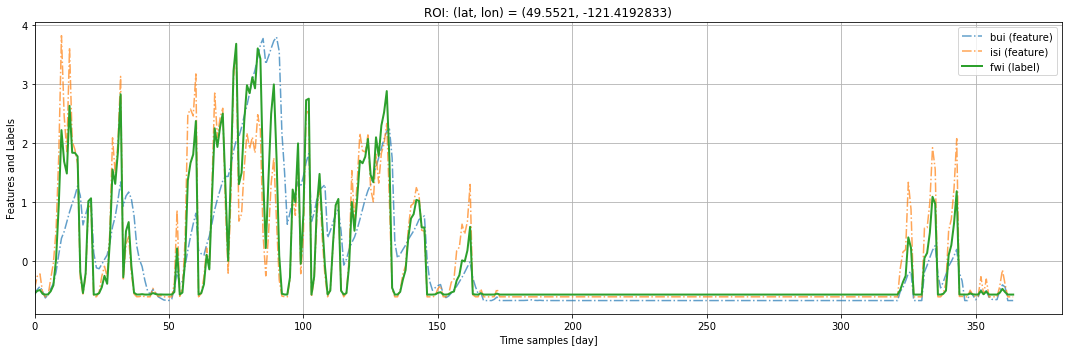

time: 349 ms


In [16]:
# see all data points

plt.figure(figsize=(15, 5))
plt.plot(np.arange(0,len(X[:,0])), X[:,0], 
         '-.', linewidth=1.5, alpha=0.7, label="bui (feature)")
plt.plot(np.arange(0,len(X[:,0])), X[:,1], 
         '-.', linewidth=1.5, alpha=0.7, label="isi (feature)")
plt.plot(np.arange(0,len(X[:,0])), y, 
         linewidth=2.0, label="fwi (label)")
plt.xlim(0)
#plt.ylim(0)
plt.title("ROI: (lat, lon) = ({}, {})".format(lat,lon))
plt.xlabel("Time samples [day]")
plt.ylabel("Features and Labels")
plt.grid()
plt.legend()

plt.tight_layout()

## Model and trainig

In [17]:
model = linear_model.SGDRegressor(
    loss="epsilon_insensitive",
    shuffle=False,
    epsilon=1e-2, 
    max_iter=1e4, 
    tol=1e-4)

time: 1.51 ms


In [18]:
i = 1
train_elements = -1  # -1 => use all test dataset

total = len(train_index)

if(train_elements!=-1):
  print("Number of train elements used: ", train_elements, "of", len(train_index))
  
score = []
while(train_index):
  # get data randomly
  fwi, bui, isi, ind_list = getRandomData(lat, lon, depth, train_index, train=1)
  train_index = ind_list
  
  # reshape
  fwi = np.reshape(fwi,(dim,1))
  bui = np.reshape(bui,(dim,1))
  isi = np.reshape(isi,(dim,1))

  # build X and y
  X = np.concatenate((bui,isi),axis=1)
  y = fwi

  # data standardization
  X, y = standardize(X, y, train=1)

  model = model.fit(X, np.ravel(y))
  
  if(i==train_elements):
    break
  
  if(len(train_index) < depth):
    break
  
  i+=1

if(train_elements==-1):
  print("Number of train elements used: ", 
        (total - len(train_index)), 
        "of", total)

Number of train elements used:  8912 of 9009
time: 972 ms


## Preliminary assessment

In the following code cells, an SVM regressor model is trained using batches of 365 days. The model's performance is then assessed based on a qualitative basis, i.e. by graphical inspection.

In [19]:
# Model Info
print("Score:", np.round(model.score(X, y),2)*100, "%")
print("Parameters:", model.get_params())

Score: 94.0 %
Parameters: {'alpha': 0.0001, 'average': False, 'early_stopping': False, 'epsilon': 0.01, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'loss': 'epsilon_insensitive', 'max_iter': 10000.0, 'n_iter_no_change': 5, 'penalty': 'l2', 'power_t': 0.25, 'random_state': None, 'shuffle': False, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
time: 5.17 ms


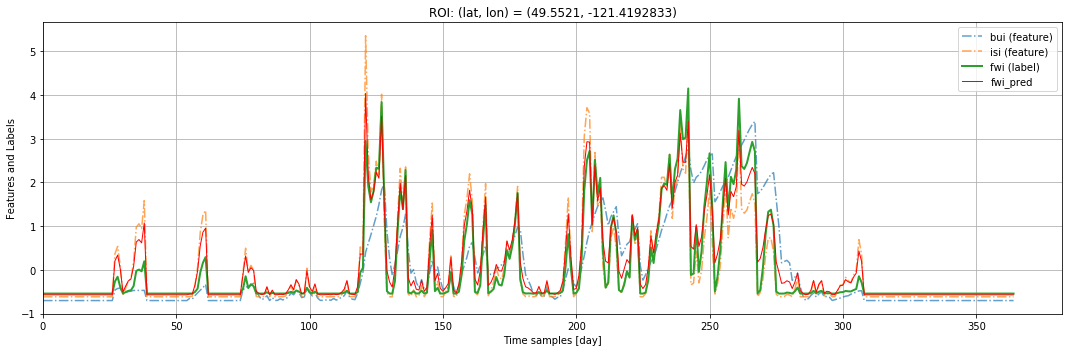

time: 362 ms


In [20]:
# fit to the data used to train
plt.figure(figsize=(15, 5))
plt.plot(np.arange(0,len(X[:,0])), X[:,0], 
         '-.', linewidth=1.5, alpha=0.7, label="bui (feature)")
plt.plot(np.arange(0,len(X[:,0])), X[:,1], 
         '-.', linewidth=1.5, alpha=0.7, label="isi (feature)")
plt.plot(np.arange(0,len(X[:,0])), y, 
         linewidth=2.0, label="fwi (label)")
plt.plot(model.predict(X), 
         '-',color='red', linewidth=1, label="fwi_pred")
plt.xlim(0)
#plt.ylim(0)
plt.title("ROI: (lat, lon) = ({}, {})".format(lat,lon))
plt.xlabel("Time samples [day]")
plt.ylabel("Features and Labels")
plt.grid()
plt.legend()

plt.tight_layout()

As shown above, the model was able to effectively capture the non-linear dinamics between the features and label. The question now, is "Can the model generalize?", i.e. how good are predictions based on unseen data.

The following cells test the model performance.

## Testing

In [21]:
i = 1
test_elements = -1  # -1 => use all test dataset

total = len(test_index)

if(test_elements!=-1):
  print("Number of train elements used: ", len(test_index), "of", len(test_index))

score = []
while(test_index):
  # get data randomly
  fwi, bui, isi, ind_list = getRandomData(lat, lon, depth, test_index, train=0)
  test_index = ind_list
  
  # reshape
  fwi = np.reshape(fwi,(dim,1))
  bui = np.reshape(bui,(dim,1))
  isi = np.reshape(isi,(dim,1))

  # build X and y
  X_i = np.concatenate((bui,isi),axis=1)
  y_i = fwi
  
  # data standardization
  X_i, y_i = standardize(X_i, y_i, train=0)
  
  # store score
  score.append(model.score(X_i, y_i))
  
  if(test_elements >= 0):
    if(i == test_elements):
      break
  
  if(len(test_index) < depth):
    break
  
  i+=1

if(train_elements==-1):
  print("Number of train elements used: ", 
        (total - len(test_index)), 
        "of", total)
  
avg_score = np.mean(score)

print("Average score: ", avg_score)

Number of train elements used:  4355 of 4687
Average score:  0.9500436684471528
time: 476 ms


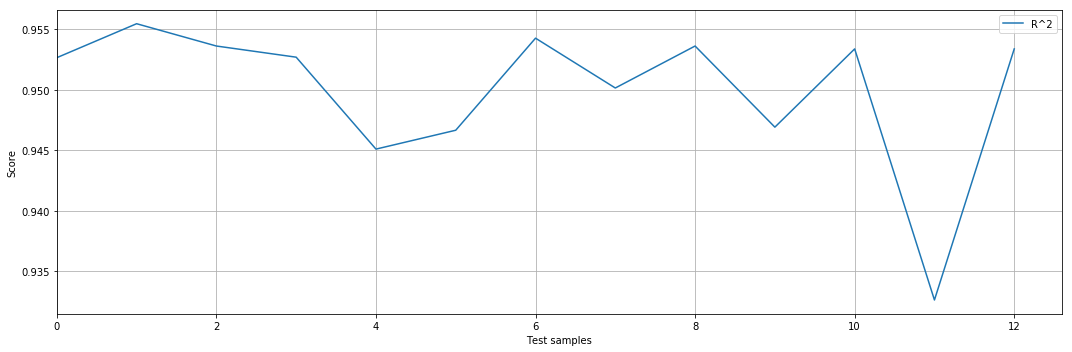

time: 291 ms


In [22]:
#tendency = savgol_filter(score, 111, 2)

plt.figure(figsize=(15, 5))
plt.plot(np.arange(len(score)), score, label="R^2")
#plt.plot(np.arange(len(score)), tendency, label="Tendency line")
plt.xlim(0)
plt.xlabel("Test samples")
plt.ylabel("Score")
plt.grid()
plt.legend()

plt.tight_layout()

As shown above, the model is able to effectively generalize, achieving an average score of 95%.

# Conclusion and future work

To determine the nonlinear dependencies between BUI, ISI, and FWI of different geographical locations, an online learning SVM model based on Stochastic Gradient Descent was employed. The proposed approach focused on capturing the *temporal* interdependencies, instead of the geographical ones. Results have shown that nonlinear relationships between features (BUI, ISI) and label (FWI) exist as expected, and the proposed approach is adequate enough since the model's performance presents an aggregate average performance socre of 95%. Future analysis must focus on fine-tunning the models' parameters, in particular the pre-defined data block depth. This notebook considered blocks of 365 days, however this may not be the most adequate amount of samples. An interesting future analysis would consist on using the same infrastructre to make predictions, rather than estimations. It would also be interesting to use two models in sequence, one focusing on the temporal and the following one on the geographical relationships between features.